In [42]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [43]:
# Import Data
adata = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/processed_h5ad/crypt_enriched_temp.h5ad')

In [ ]:
sc.tl.leiden(adata, resolution = 0.35, random_state = 1)

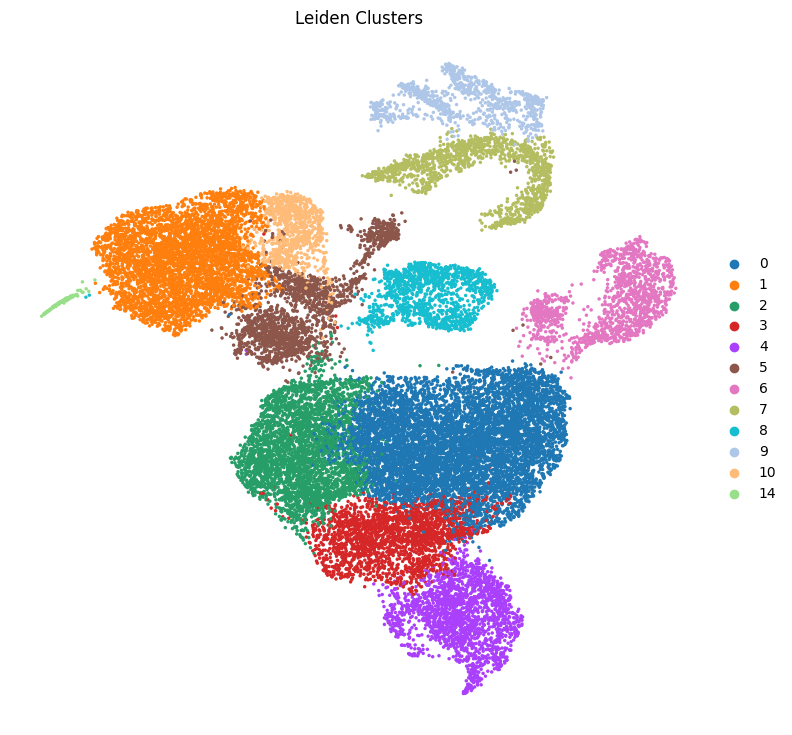

In [44]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    size=25,
    ax=ax,
    title = 'Leiden Clusters'
)

# Show the plot
plt.show()

## Functions to help with annotation

In [252]:
def combine_clusters(adata, annotation_name, clusters_to_combine):
    """
    Combine specified clusters into one cluster in the given AnnData object and display before and after UMAPs.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation_name : str
        The name of the annotation column in adata.obs to be modified.
    clusters_to_combine : list
        List of cluster names to be combined.

    Returns:
    --------
    None. The function modifies the adata object in-place and displays UMAPs.
    """
    # Manually extract the numerical suffix from the annotation name
    annotation_base = annotation_name.rstrip('0123456789')
    annotation_number = annotation_name[len(annotation_base):]

    if annotation_number.isdigit():
        new_annotation_name = annotation_base + str(int(annotation_number) + 1)
    else:
        # Append '0' if the annotation name does not end with a number
        new_annotation_name = annotation_name + '0'

    # Create a new annotation column
    adata.obs[new_annotation_name] = adata.obs[annotation_name].copy()

    # Print the new annotation name
    print(f"New annotation name: {new_annotation_name}")

    # Plot the UMAP before combining clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation_name], ax=ax1, show=False, title='Before combining clusters - ' + annotation_name, size=20)

    # Set the target label as the first cluster in the list
    target_label = clusters_to_combine[0]

    # Extract the current cluster labels
    cluster_labels = adata.obs[new_annotation_name]

    # Update cluster labels for the specified clusters
    adata.obs[new_annotation_name] = cluster_labels.apply(lambda x: target_label if x in clusters_to_combine else x)

    # Plot the UMAP after combining clusters
    sc.pl.umap(adata, color=[new_annotation_name], ax=ax2, show=False, title='After combining clusters - ' + new_annotation_name, size=20)

    plt.tight_layout()
    plt.show()


In [46]:
def recluster_subset(adata, annotation_name, cluster_name, new_annotation_name, resolution):
    """
    Recluster a specific subset of cells using Leiden algorithm.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation_name : str
        The name of the annotation column to use for subsetting.
    cluster_name : str
        The name of the cluster to recluster.
    new_annotation_name : str
        The name of the new annotation column to store the results.
    resolution : float
        The resolution parameter for the Leiden algorithm.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
        # Plot the UMAP before reclustering
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation_name], ax=ax1, show=False, title='Before Reclustering - ' + annotation_name, size = 20)

    sc.tl.leiden(adata, restrict_to=(annotation_name, [cluster_name]), 
                 key_added=new_annotation_name, resolution=resolution, random_state=1)
    
    # Plot the UMAP after reclustering
    sc.pl.umap(adata, color=[new_annotation_name], ax=ax2, show=False, title='After Reclustering - ' + new_annotation_name, size = 20)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# recluster_subset(adata, 'EEC_refined_final', 'EE progenitor', 'final_annotations', 0.2)

In [47]:
def plot_gene_heatmap_umap(adata, genes, size = 30):
    """
    Plot heatmap UMAPs for a list of genes in an AnnData object.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to plot.

    Returns:
    --------
    None. The function displays the plots.
    """
    num_genes = len(genes)
    fig, axes = plt.subplots(1, num_genes, figsize=(6*num_genes, 6))
    
    if num_genes == 1:
        axes = [axes]
    
    for ax, gene in zip(axes, genes):
        sc.pl.umap(
            adata,
            color=gene,
            title=f'UMAP Heatmap - {gene}',
            frameon=False,
            ax=ax,
            size=size,
            color_map='viridis',
            show=False
        )
        
        ax.set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_gene_heatmap_umap(adata, ['Gene1', 'Gene2', 'Gene3'])

In [48]:
def plot_combined_gene_heatmap_umap(adata, genes, size=30):
    """
    Plot a combined heatmap UMAP for a list of genes in an AnnData object.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to plot.
    size : int, optional
        Size of the points in the plot. Default is 30.

    Returns:
    --------
    None. The function displays the plot.
    """
    # Create a new AnnData object with only the specified genes
    adata_subset = adata[:, genes].copy()
    
    # Normalize the expression values for each gene
    sc.pp.scale(adata_subset)
    
    # Calculate the average expression across all genes
    adata_subset.obs['combined_expression'] = adata_subset.X.mean(axis=1)
    
    # Plot the combined heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sc.pl.umap(
        adata_subset,
        color='combined_expression',
        title='Combined Gene Expression Heatmap',
        frameon=False,
        ax=ax,
        size=size,
        color_map='viridis',
        show=False
    )
    
    ax.set_facecolor('black')
    
    # Add gene names to the plot legend
    ax.text(1.05, 1, ', '.join(genes), transform=ax.transAxes, va='top', ha='left', fontsize=10, wrap=True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_combined_gene_heatmap_umap(adata, ['Gene1', 'Gene2', 'Gene3'])

In [123]:
def divide_cluster_by_expression(adata, genes, cluster_name, annotation, x=0.2, size=30, fig_size=1):
    """
    Divide a specified cluster into two groups based on the combined expression of a list of genes.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to calculate combined expression.
    cluster_name : str
        The name of the cluster to divide.
    annotation : str
        The name of the annotation column in `adata.obs` to use for cluster identification. Default is 'leiden1'.
    x : float, optional
        The top portion of expressors to include in the first group (e.g., 0.2 for top 20%). Default is 0.2.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
    # Manually extract the numerical suffix from the annotation name
    annotation_base = annotation.rstrip('0123456789')
    annotation_number = annotation[len(annotation_base):]

    if annotation_number.isdigit():
        new_annotation = annotation_base + str(int(annotation_number) + 1)
    else:
        # Append '0' if the annotation name does not end with a number
        new_annotation = annotation + '0'

    # Create a new AnnData object with only the specified genes
    adata_subset = adata[:, genes].copy()

    # Plot the UMAP before dividing clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12 * fig_size, 6 * fig_size))
    sc.pl.umap(adata, color=[annotation], ax=ax1, show=False, title='Before Dividing - ' + annotation, size=size)

    # Normalize the expression values for each gene
    sc.pp.scale(adata_subset)

    # Calculate the average expression across all genes
    adata_subset.obs['combined_expression'] = adata_subset.X.mean(axis=1)

    # Identify the cells in the specified cluster using the provided annotation
    cluster_mask = adata.obs[adata.obs[annotation] == cluster_name].index

    # Subset to cells within the specified cluster
    cluster_subset = adata_subset[cluster_mask].copy()

    # Create a new column based on the original annotation to retain other clusters' names
    adata.obs[new_annotation] = adata.obs[annotation]

    # Ensure the new categories exist in the column
    adata.obs[new_annotation] = adata.obs[new_annotation].astype('category')
    adata.obs[new_annotation] = adata.obs[new_annotation].cat.add_categories([f'{cluster_name},0', f'{cluster_name},1'])

    # Determine the threshold for top x% expressors
    threshold = cluster_subset.obs['combined_expression'].quantile(1 - x)

    # Update the cells in the specified cluster with new cluster names
    adata.obs.loc[cluster_mask, new_annotation] = f'{cluster_name},0'
    adata.obs.loc[cluster_mask[cluster_subset.obs['combined_expression'] >= threshold], new_annotation] = f'{cluster_name},1'

    # Plot the UMAP after dividing clusters
    sc.pl.umap(adata, color=[new_annotation], ax=ax2, show=False, title='After Dividing - ' + new_annotation, size=size)

    plt.tight_layout()
    plt.show()

In [114]:
def rename_clusters(adata, annotation, rename_dict):
    """
    Rename clusters in a specified annotation column based on a given dictionary.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation : str
        The name of the annotation column in `adata.obs` to be renamed.
    rename_dict : dict
        A dictionary where the keys are the original cluster names and the values are the new cluster names.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
    # Plot the UMAP before reclustering
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation], ax=ax1, show=False, title = annotation, size = 20)

    # Ensure the annotation column is categorical
    adata.obs[annotation] = adata.obs[annotation].astype('category')

    # Rename the categories based on the dictionary
    adata.obs[annotation] = adata.obs[annotation].cat.rename_categories(rename_dict)

    # If there are unused categories, remove them
    adata.obs[annotation] = adata.obs[annotation].cat.remove_unused_categories()

    # Plot the UMAP after reclustering
    sc.pl.umap(adata, color=[annotation], ax=ax2, show=False, title = annotation, size = 20)
    
    plt.tight_layout()
    plt.show()

In [243]:
def rename_cluster(adata, annotation, old_cluster, new_cluster):
    """
    Rename a single cluster in a specified annotation column based on provided cluster names.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation : str
        The name of the annotation column in `adata.obs` to be renamed.
    old_cluster : str
        The name of the cluster to be renamed.
    new_cluster : str
        The new name for the cluster.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
    # Plot the UMAP before renaming
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation], ax=ax1, show=False, title=f'{annotation} (Before)', size=20)

    # Ensure the annotation column is categorical
    adata.obs[annotation] = adata.obs[annotation].astype('category')

    # Rename the specified cluster
    adata.obs[annotation] = adata.obs[annotation].cat.rename_categories({old_cluster: new_cluster})

    # If there are unused categories, remove them
    adata.obs[annotation] = adata.obs[annotation].cat.remove_unused_categories()

    # Plot the UMAP after renaming
    sc.pl.umap(adata, color=[annotation], ax=ax2, show=False, title=f'{annotation} (After)', size=20)
    
    plt.tight_layout()
    plt.show()

In [107]:
def compare_annotations(adata, annotation_1, annotation_2):
    # Plot the UMAP before reclustering
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation_1], ax=ax1, show=False, title = annotation_1, size = 20)

    # Plot the UMAP after reclustering
    sc.pl.umap(adata, color=[annotation_2], ax=ax2, show=False, title = annotation_2, size = 20)
    
    plt.tight_layout()
    plt.show()

In [241]:
def evaluate_cluster_agreeance(adata, annotation_ref, cluster_ref, annotation_qry, cluster_qry, size=10, fig_size=1):
    """
    Evaluate the agreement between a reference cluster and a query cluster based on two different annotations.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation_ref : str
        The name of the reference annotation column in adata.obs.
    cluster_ref : str
        The name of the cluster in the reference annotation to compare.
    annotation_qry : str
        The name of the query annotation column in adata.obs.
    cluster_qry : str
        The name of the cluster in the query annotation to compare.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
    # Create a new column for the agreement status
    adata.obs['agreeance_annotation'] = 'NA'
    
    # Get the masks for the conditions
    mask_ref_match_qry_match = (adata.obs[annotation_ref] == cluster_ref) & (adata.obs[annotation_qry] == cluster_qry) # True Positive
    mask_ref_match_qry_no_match = (adata.obs[annotation_ref] == cluster_ref) & (adata.obs[annotation_qry] != cluster_qry) # False Negative
    mask_ref_no_match_qry_match = (adata.obs[annotation_ref] != cluster_ref) & (adata.obs[annotation_qry] == cluster_qry) # False Positive
    mask_ref_no_match_qry_no_match = (adata.obs[annotation_ref] != cluster_ref) & (adata.obs[annotation_qry] != cluster_qry) # True Negative
    
    # Assign values based on the conditions
    adata.obs.loc[mask_ref_match_qry_match, 'agreeance_annotation'] = 'TP'
    adata.obs.loc[mask_ref_match_qry_no_match, 'agreeance_annotation'] = 'RP'
    adata.obs.loc[mask_ref_no_match_qry_match, 'agreeance_annotation'] = 'QP'
    adata.obs.loc[mask_ref_no_match_qry_no_match, 'agreeance_annotation'] = 'TN'

    # Define color mapping for the new annotation
    color_map = {
        'TP': '#51fc02',    # True Positive
        'RP': '#fc0213',    # dark red
        'QP': '#fc6771',    # light red
        'TN': 'lightgrey'   # True Negative
    }

    # Assign colors to each category
    adata.uns['agreeance_annotation_colors'] = [color_map.get(cat, 'grey') for cat in ['TP', 'RP', 'QP', 'TN']]
    
    # Extract UMAP coordinates
    umap_coords = adata.obsm['X_umap']
    
    # Create a color array based on the mapping
    colors = np.array([color_map[ann] for ann in adata.obs['agreeance_annotation']])

    # Plot the UMAP
    fig, ax = plt.subplots(figsize=(6*fig_size, 6*fig_size))  # Adjust the figsize values as needed
    
    # Plot True Negatives (TN) first
    tn_mask = adata.obs['agreeance_annotation'] == 'TN'
    ax.scatter(umap_coords[tn_mask, 0], umap_coords[tn_mask, 1], color='lightgrey', s=size, label='TN', edgecolor='none')
    
    # Plot True Positives (TP) next
    tp_mask = adata.obs['agreeance_annotation'] == 'TP'
    ax.scatter(umap_coords[tp_mask, 0], umap_coords[tp_mask, 1], color='#51fc02', s=size, label='TP', edgecolor='none')

    # Plot False Positives (QP)
    QP_mask = adata.obs['agreeance_annotation'] == 'QP'
    ax.scatter(umap_coords[QP_mask, 0], umap_coords[QP_mask, 1], color='#fc6771', s=size, label='QP', edgecolor='none')

    # Plot False Negatives (RP)
    RP_mask = adata.obs['agreeance_annotation'] == 'RP'
    ax.scatter(umap_coords[RP_mask, 0], umap_coords[RP_mask, 1], color='#fc0213', s=size, label='RP', edgecolor='none')

    # Add legend and titles
    ax.legend()
    ax.set_title('Agreeance')
    
    # Show the plot
    plt.show()


In [50]:
# Marker Gene Dictionary
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1', 'Alpi', 'Apoa1', 'Apoa4', 'Lct'],
               'Goblet': ['Muc2', 'Tff3', 'Agr2', 'Spdef', 'Klf4', 'Tff3', 'Ccl9', 'Manf'],
               'Goblet progenitor': ['Spdef', 'Atoh1'],
               'Paneth': ['Lyz1', 'Mmp7', 'Defa17', 'Defa22', 'Ang4'],
               'EEC': ['Neurod1', 'Neurod2', 'Insm1', 'Chga', 'Chgb'],
               'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft': ['Dclk1', 'Trpm5', 'Gfi1b', 'Il25'],
               'Lymphocyte': ['Coro1a', 'Cd52', 'Cd37']
               }

## Annotation  
Strategy to be employed here utilises the functions detailed above, general steps are as follows:  
  
1. View marker gene feature plots for cell type to be annotated using `plot_gene_heatmap_umap` and `plot_combined_gene_heatmap_umap`.  
2. Create a cluster using a combination of `recluster_subset`, `divide_cluster_by_expression` and `combine_clusters` based off the previous step.  
3. Rename the cluster using `rename_clusters`.
4. If a reference annotation is provided, or a different person also annotated the data, the two annotations can be compared with `compare_annotations` and `evaluate_cluster_agreeance`.

### ISC Annotation

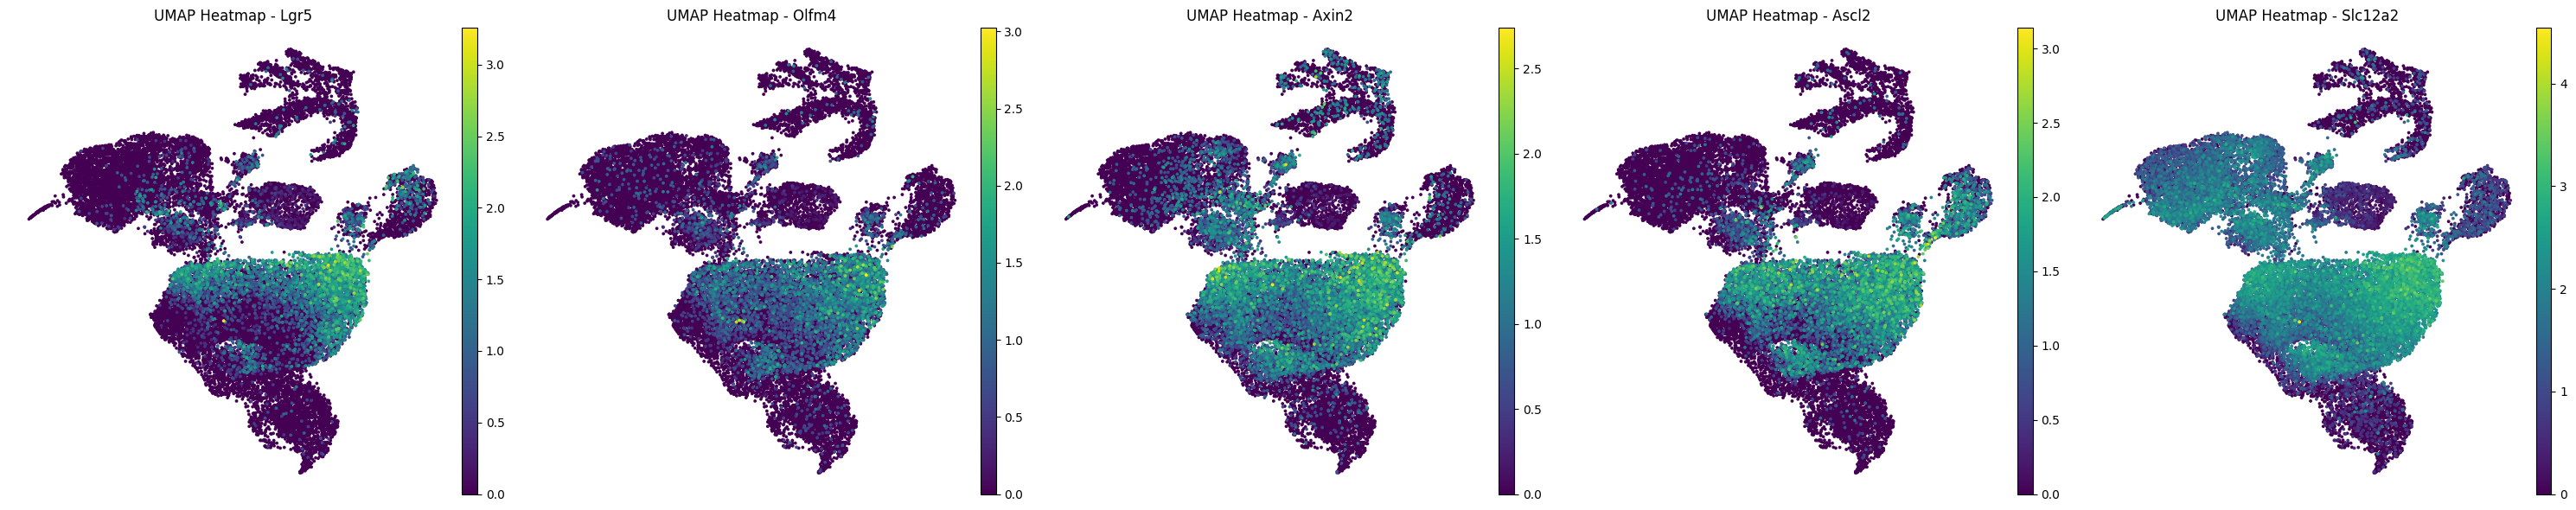

In [120]:
plot_gene_heatmap_umap(adata, marker_dict['ISC'])

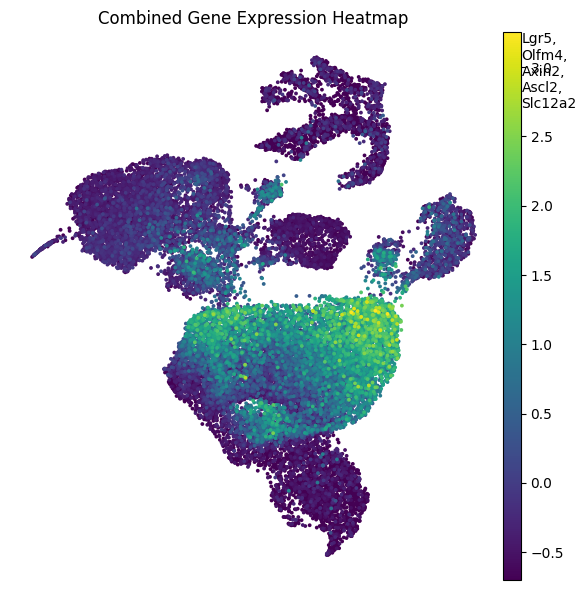

In [121]:
plot_combined_gene_heatmap_umap(adata, genes = marker_dict['ISC'])

New annotation name: leiden1


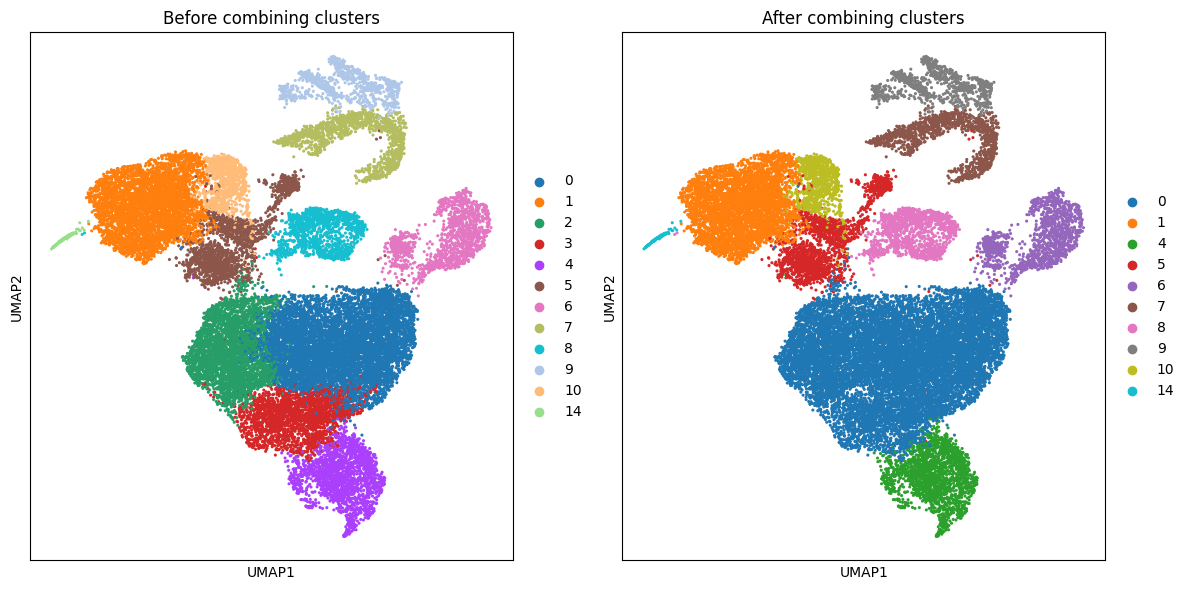

In [51]:
clusters_to_combine = ['0','2','3']
combine_clusters(adata, 'leiden', clusters_to_combine)

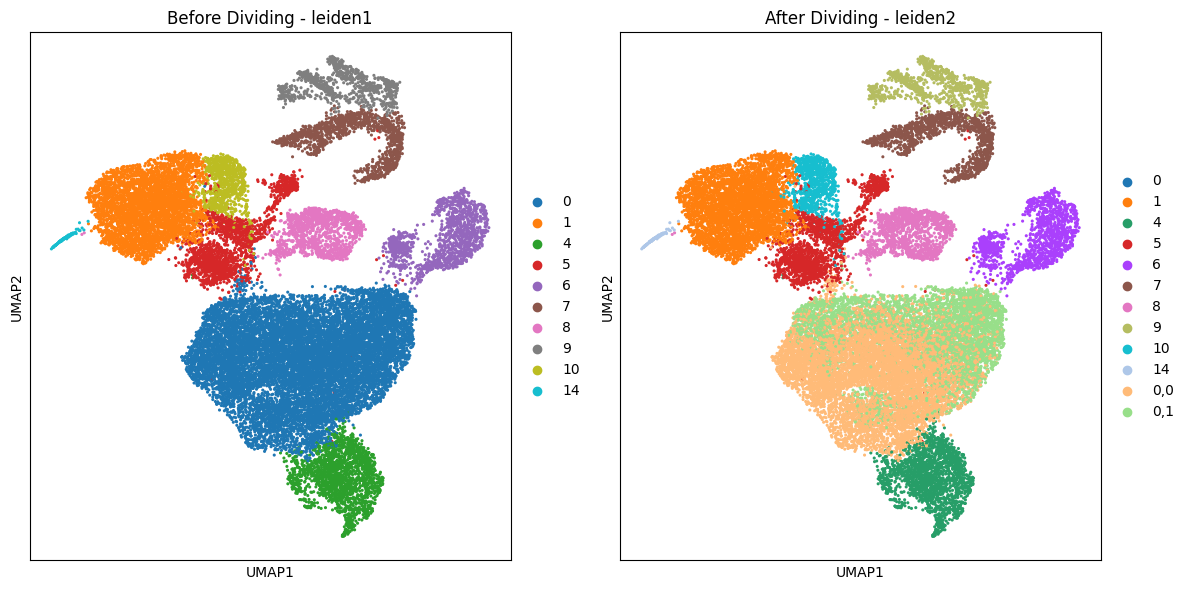

In [239]:
divide_cluster_by_expression(adata, marker_dict['ISC'], '0', annotation='leiden1', x = 0.35, size = 20)

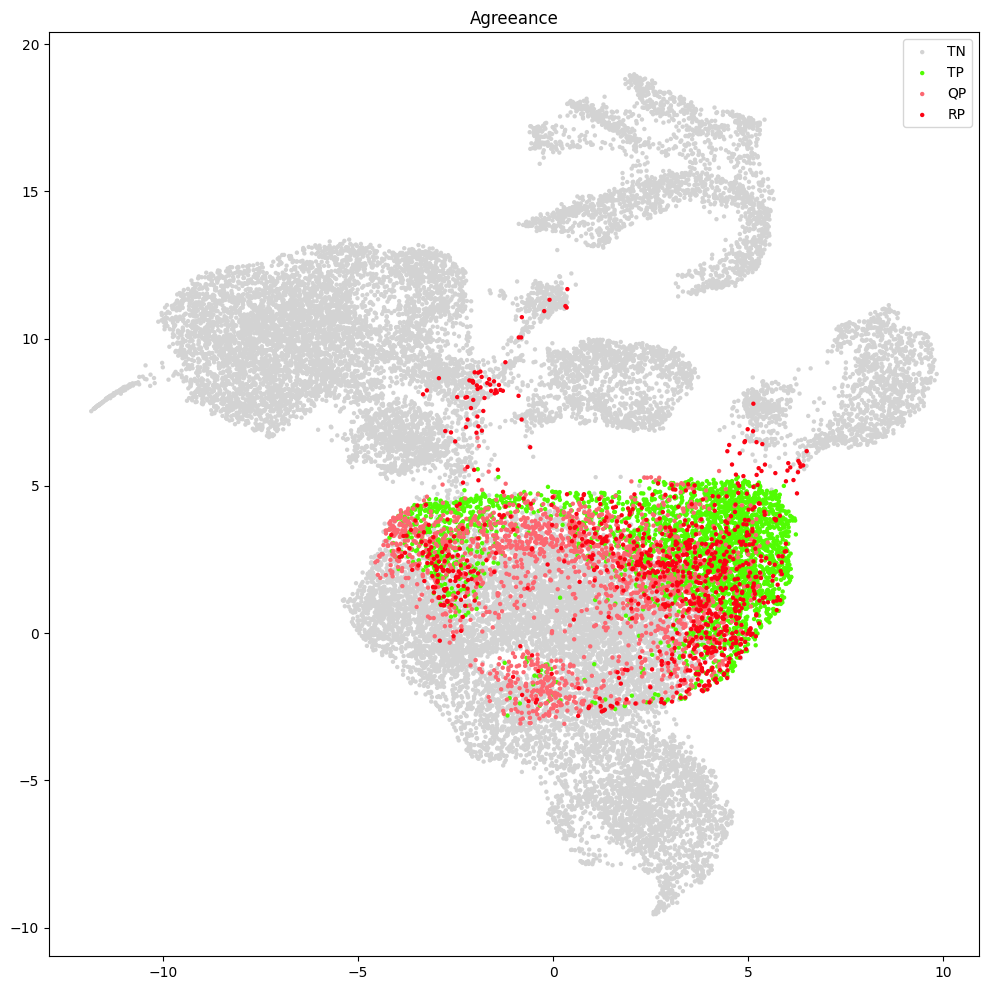

In [242]:
evaluate_cluster_agreeance(adata, annotation_ref='published_annotations', cluster_ref='ISC', annotation_qry= 'leiden2', cluster_qry='0,1', fig_size=2, size = 10)

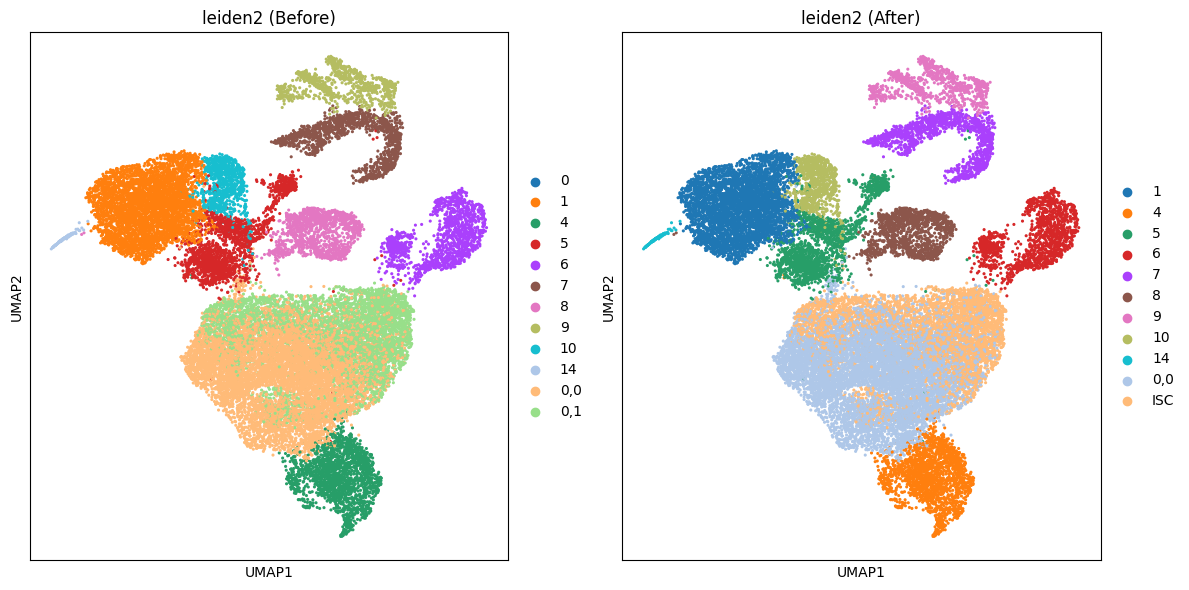

In [244]:
rename_cluster(adata, 'leiden2', '0,1', 'ISC')

## Enterocytes

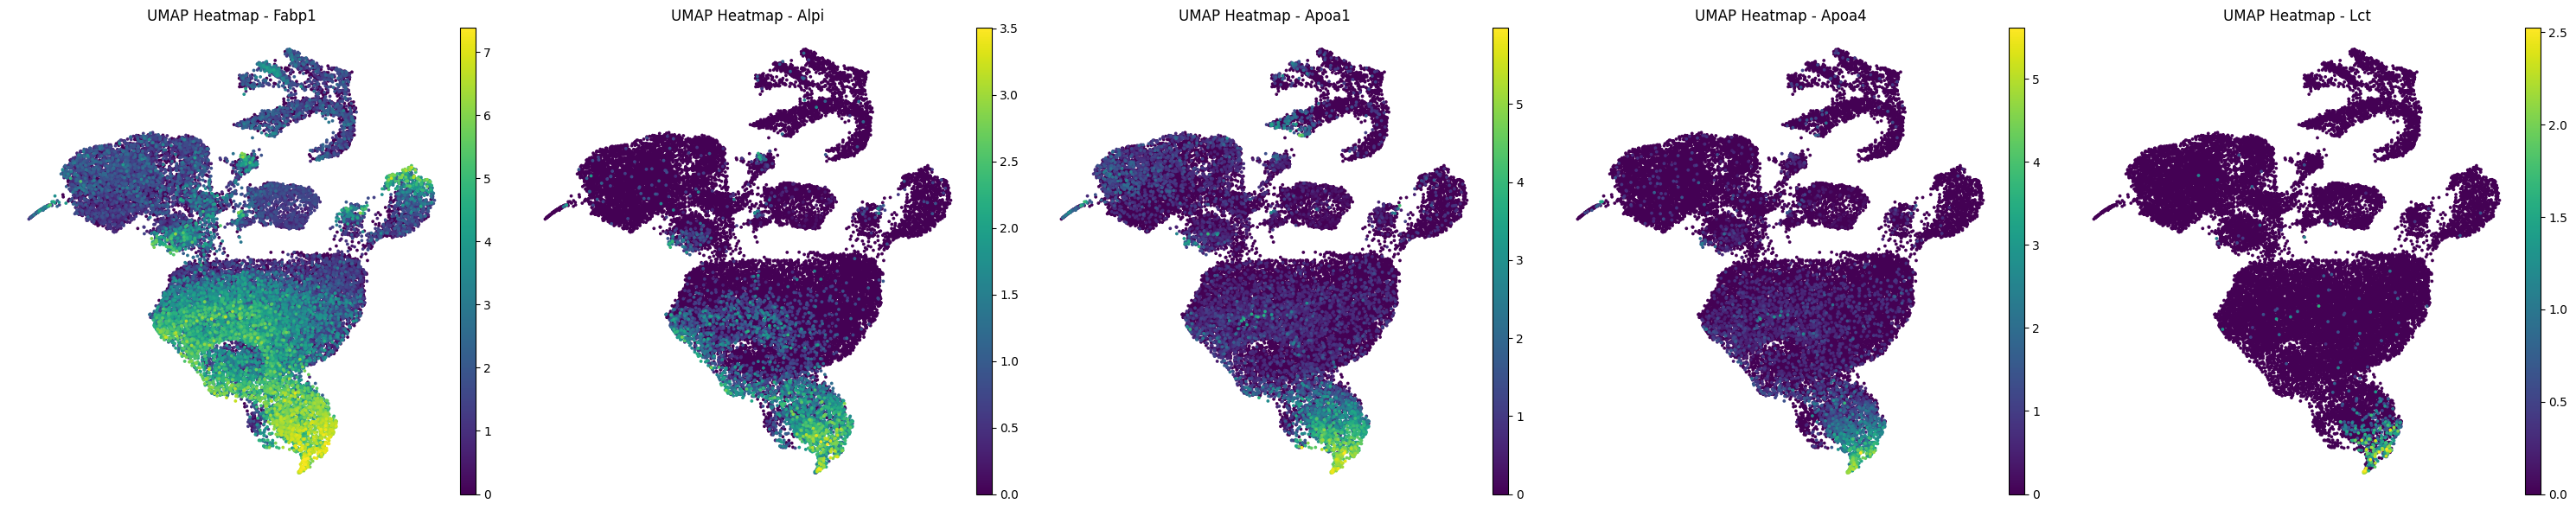

In [245]:
plot_gene_heatmap_umap(adata, marker_dict['Enterocyte'])

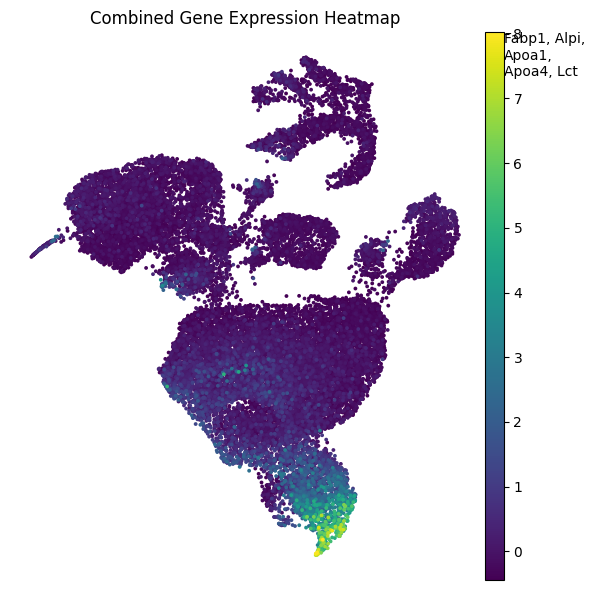

In [246]:
plot_combined_gene_heatmap_umap(adata, genes = marker_dict['Enterocyte'])

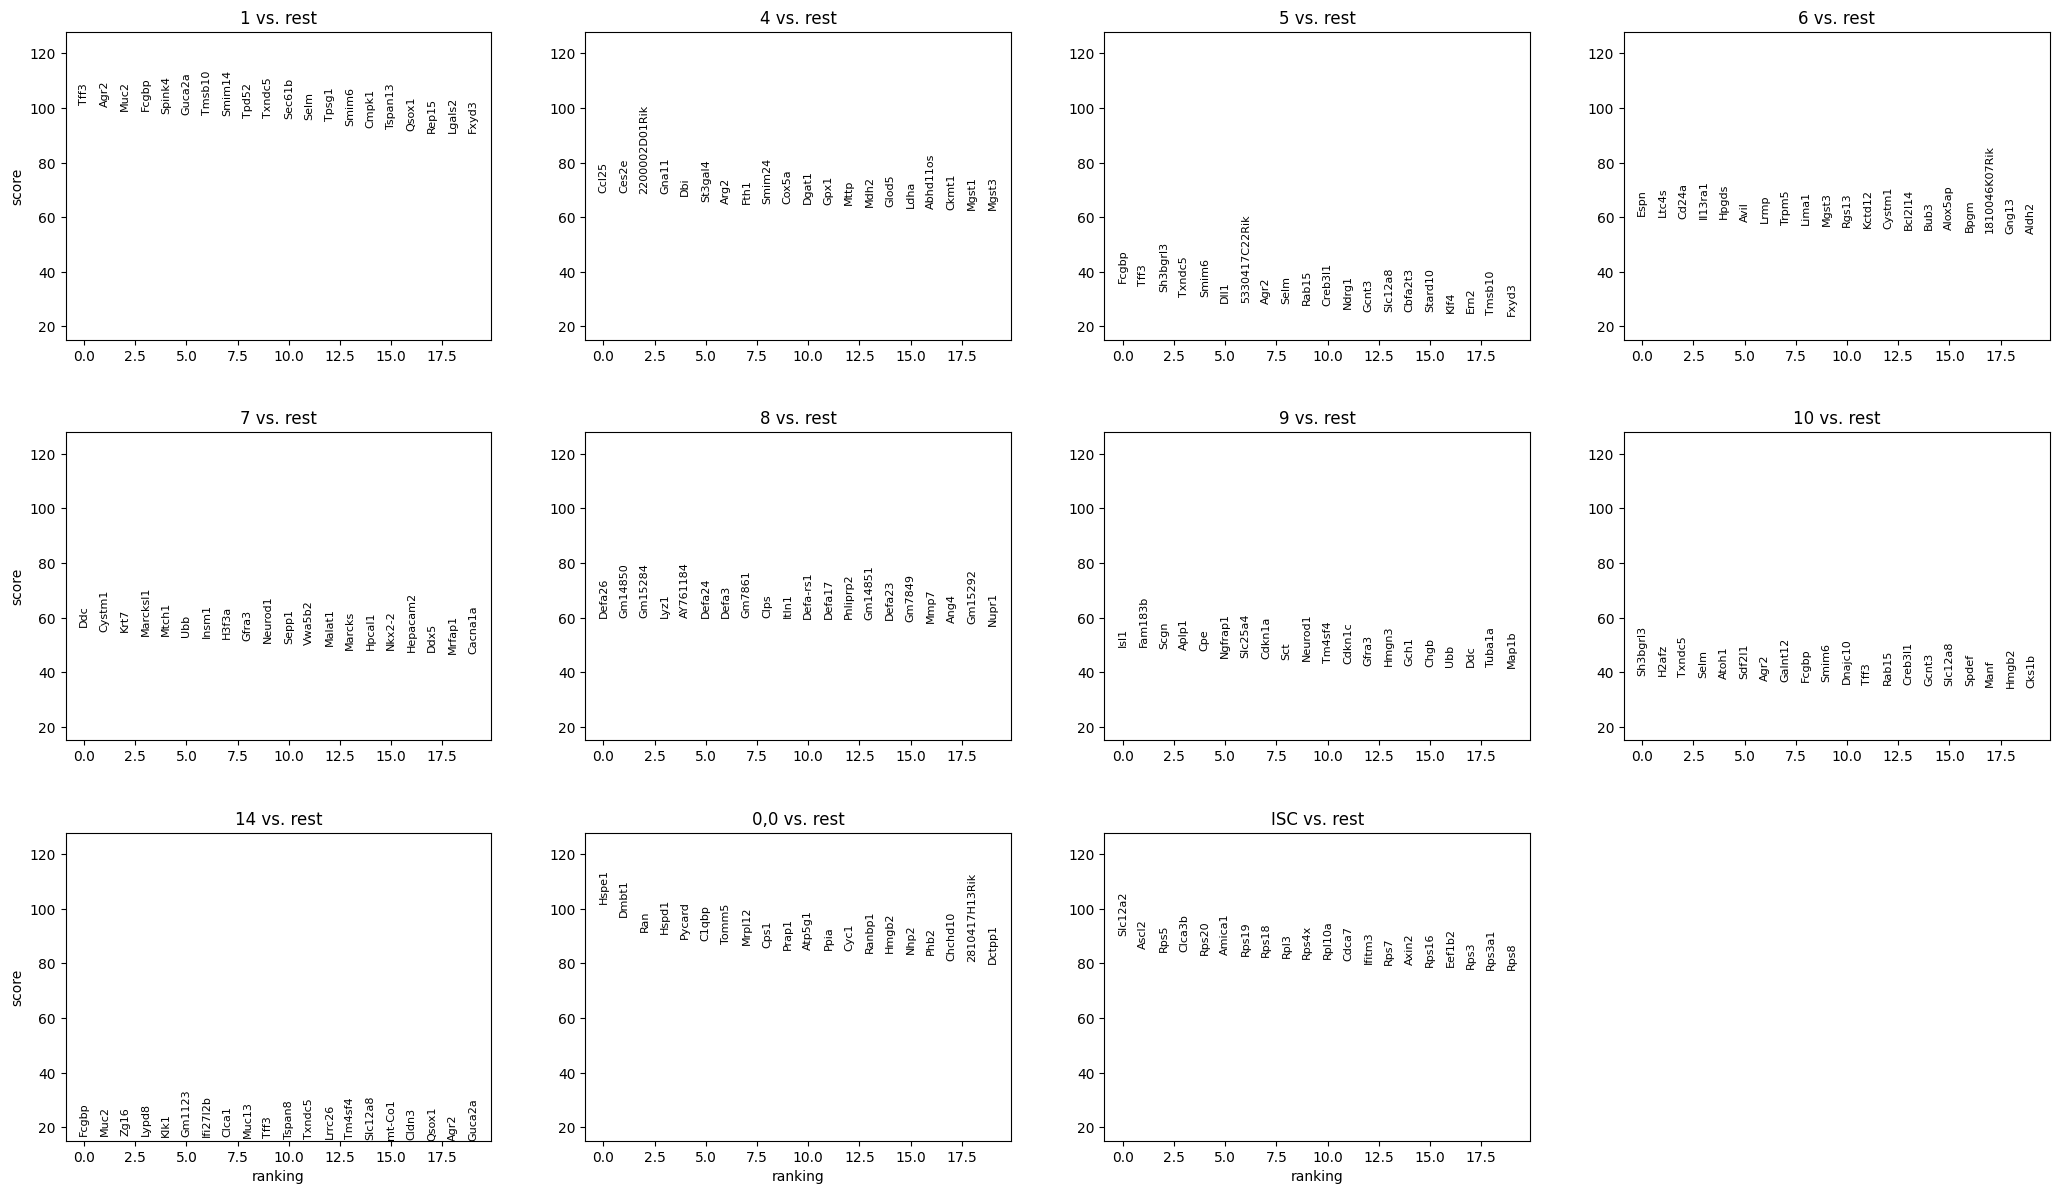

In [275]:
sc.tl.rank_genes_groups(adata, 'leiden2', method='wilcoxon')

# to visualize the results

sc.pl.rank_genes_groups(adata)

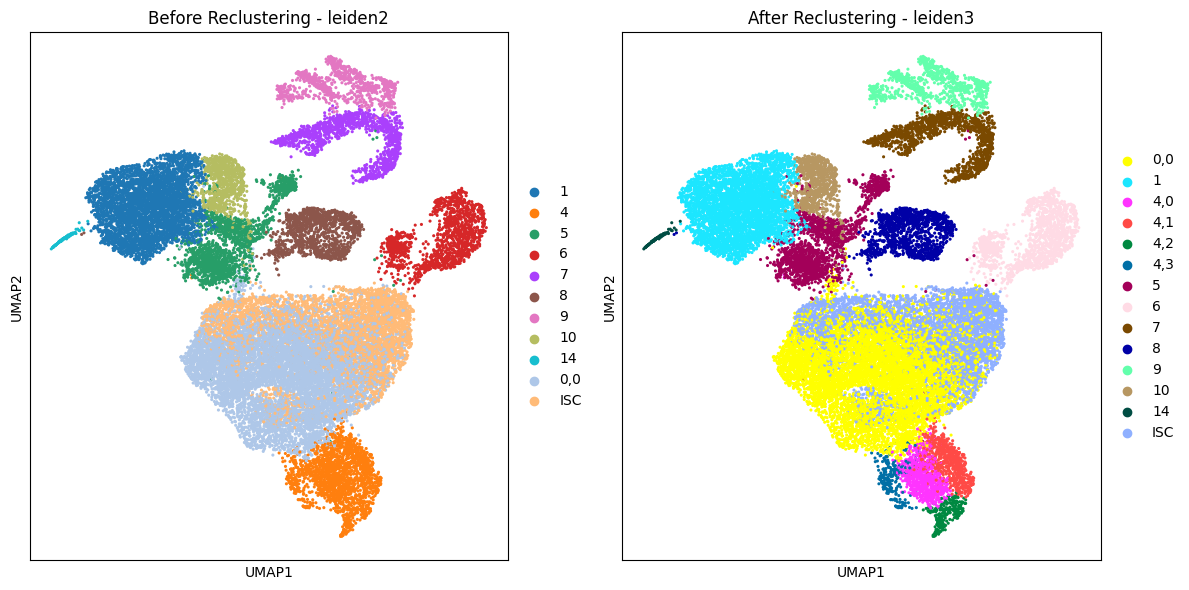

In [273]:
recluster_subset(adata, annotation_name='leiden2', cluster_name='4', new_annotation_name='leiden3', resolution=0.15)

/home/glennrdx/.cursor-tutor-2/.venv/lib/python3.12/site-packages/numba/core/dispatcher.py:244: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()


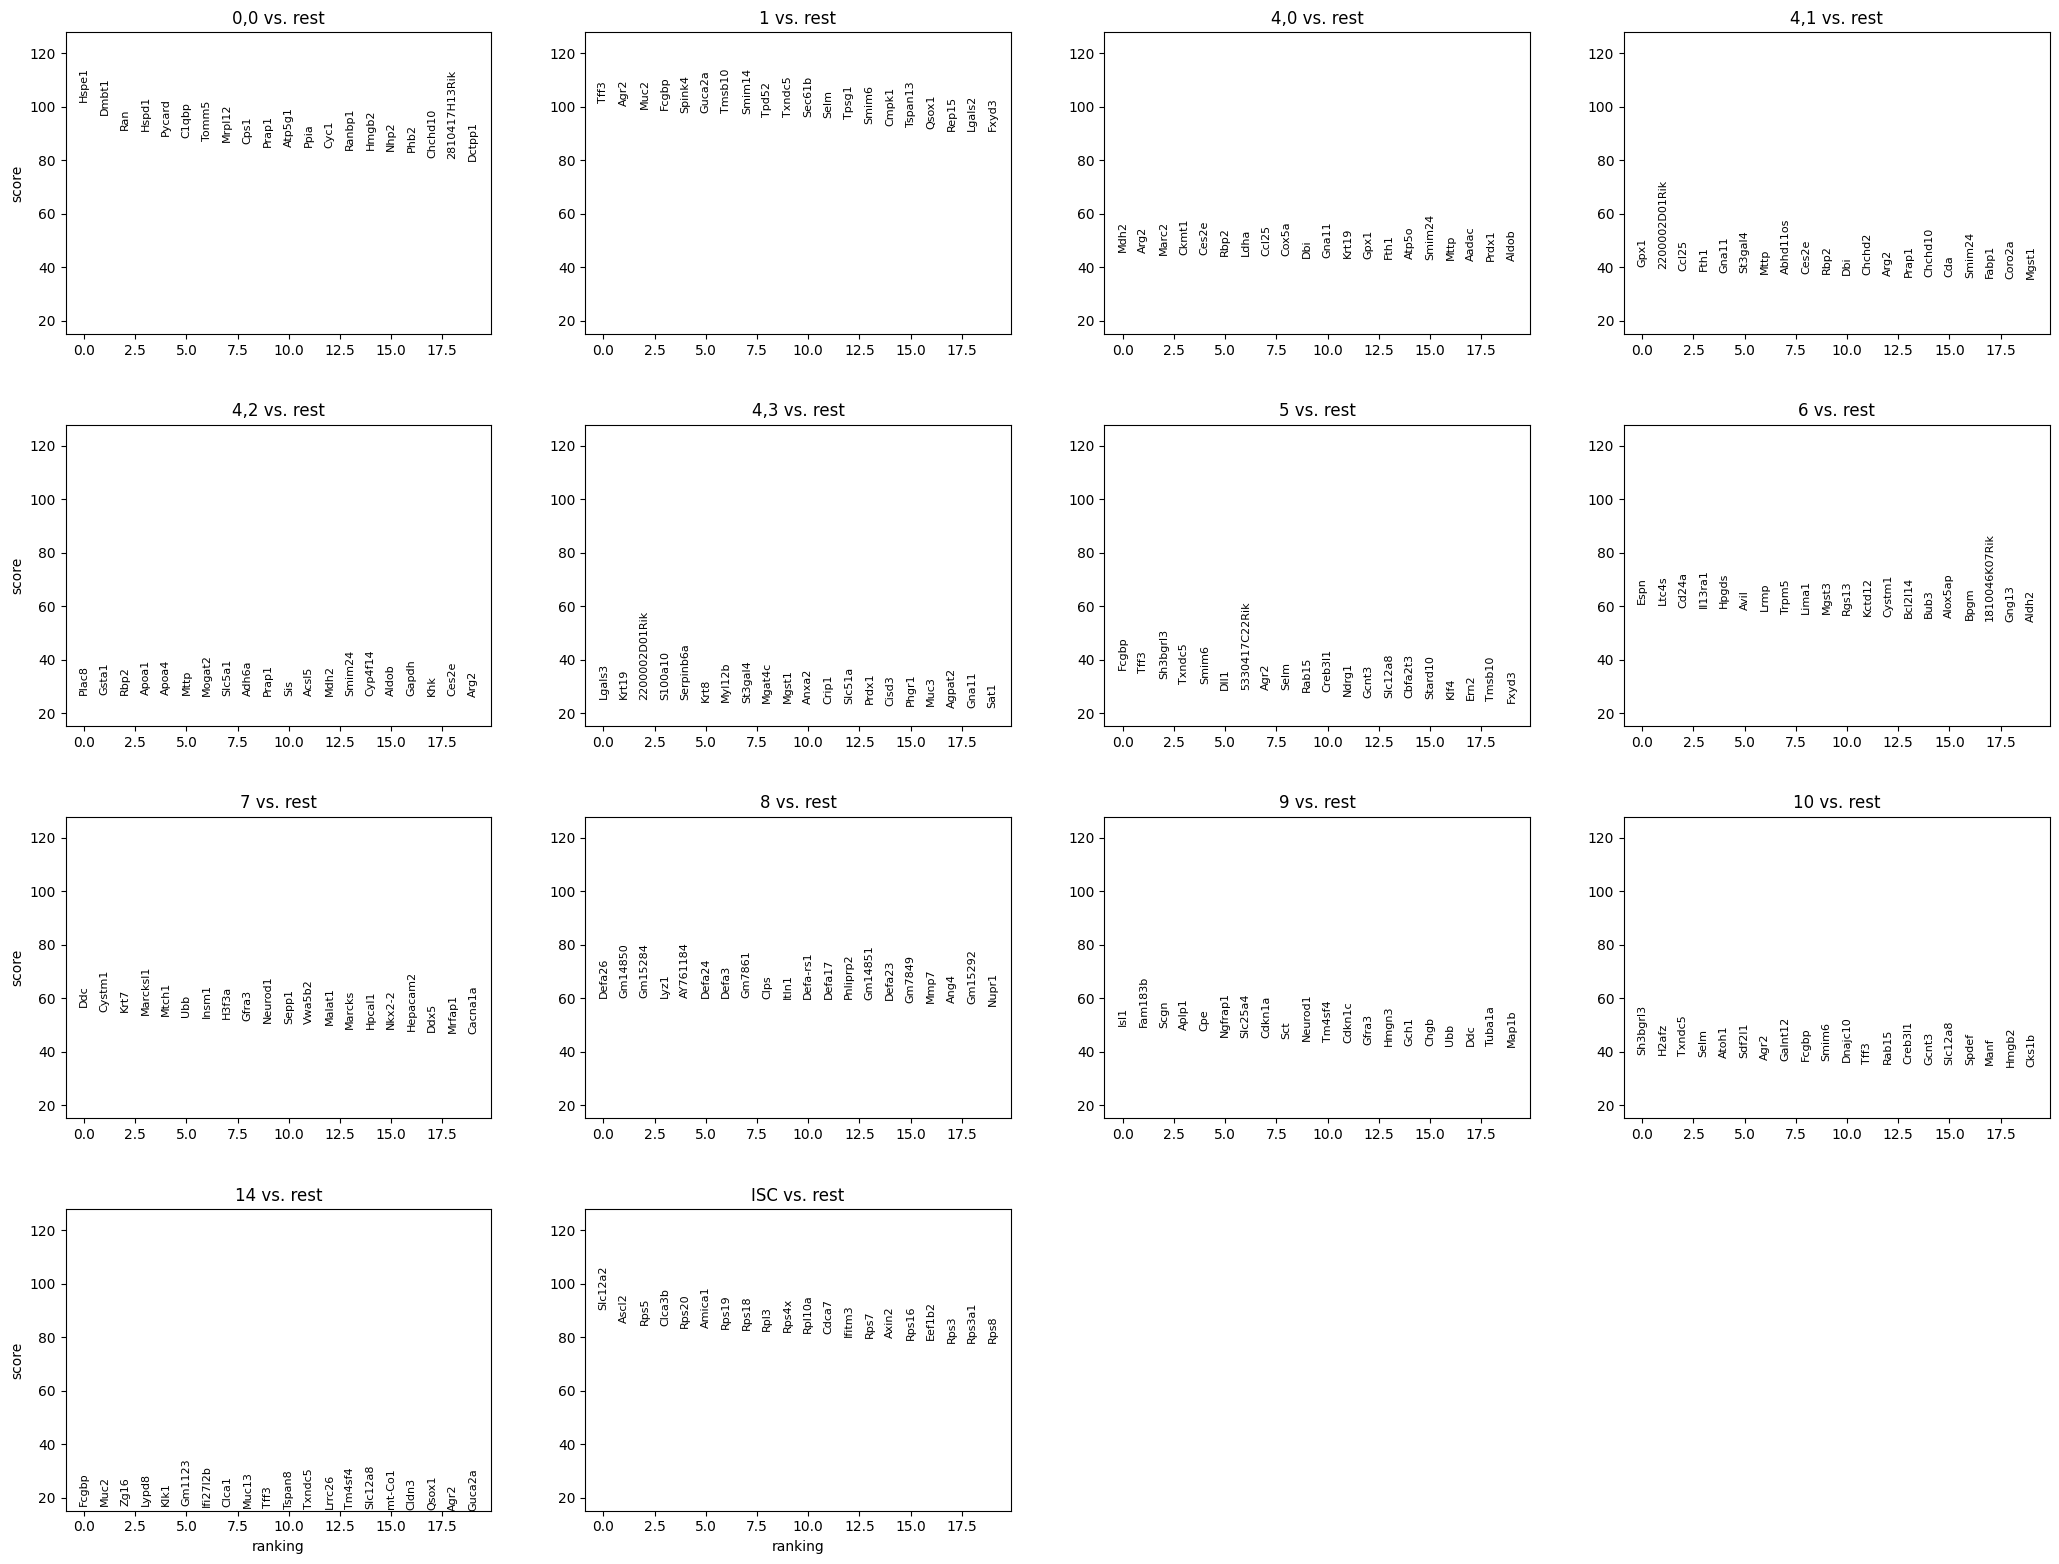

In [274]:
sc.tl.rank_genes_groups(adata, 'leiden3', method='wilcoxon')

# to visualize the results

sc.pl.rank_genes_groups(adata)

New annotation name: leiden3


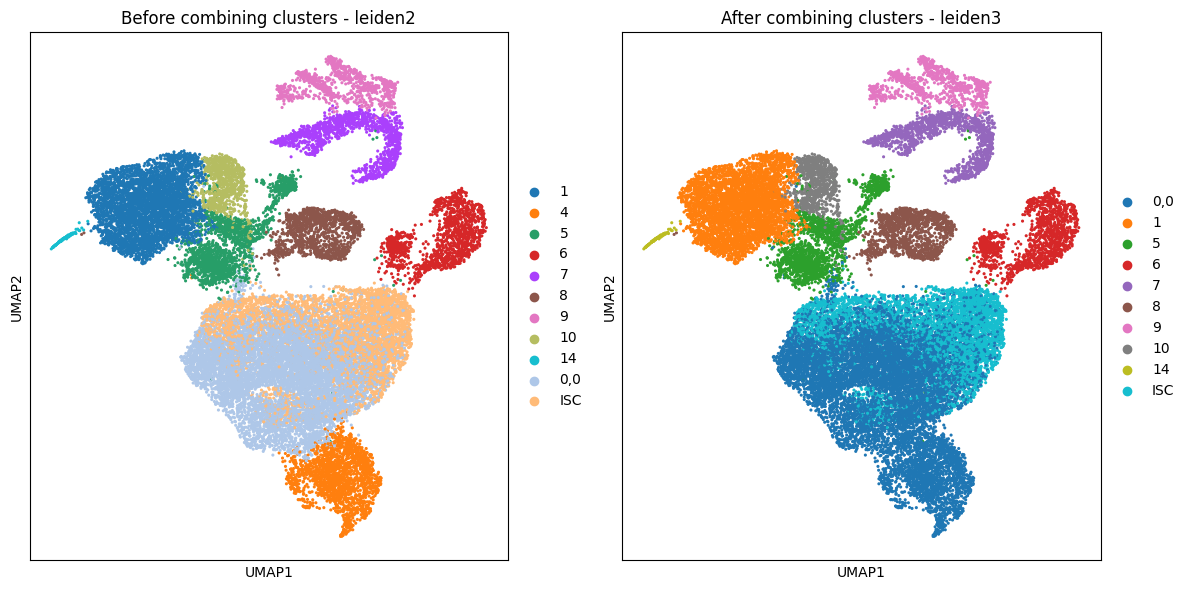

In [253]:
# combine_clusters(adata, 'leiden2', ['0,0','4'])

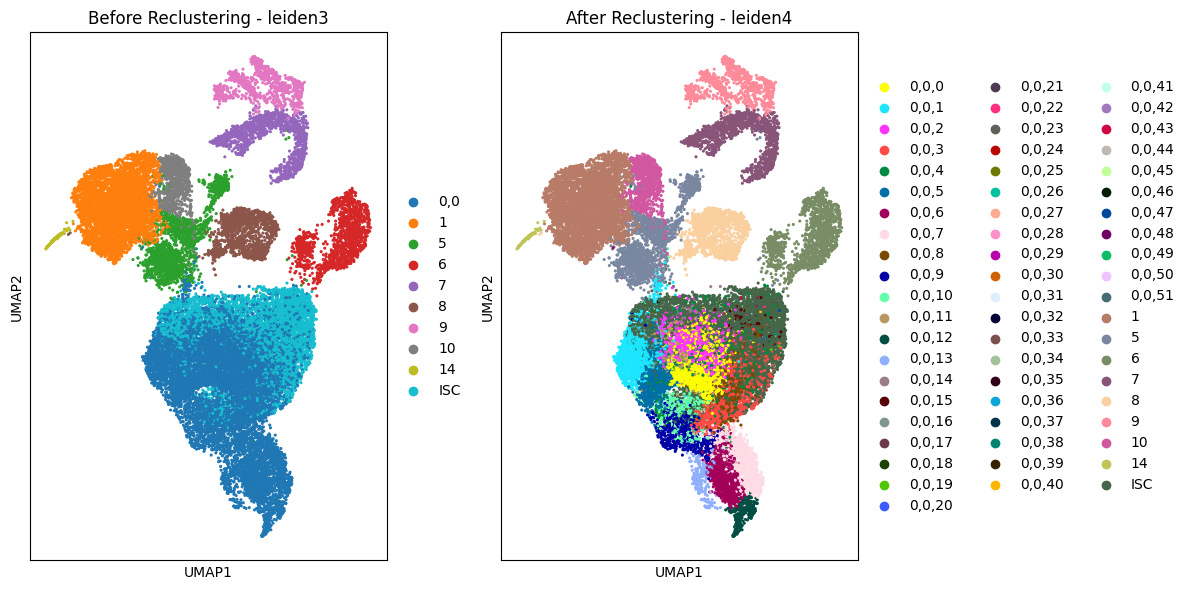

In [265]:
# recluster_subset(adata, annotation_name='leiden3', cluster_name='0,0', new_annotation_name='leiden4', resolution=0.75)

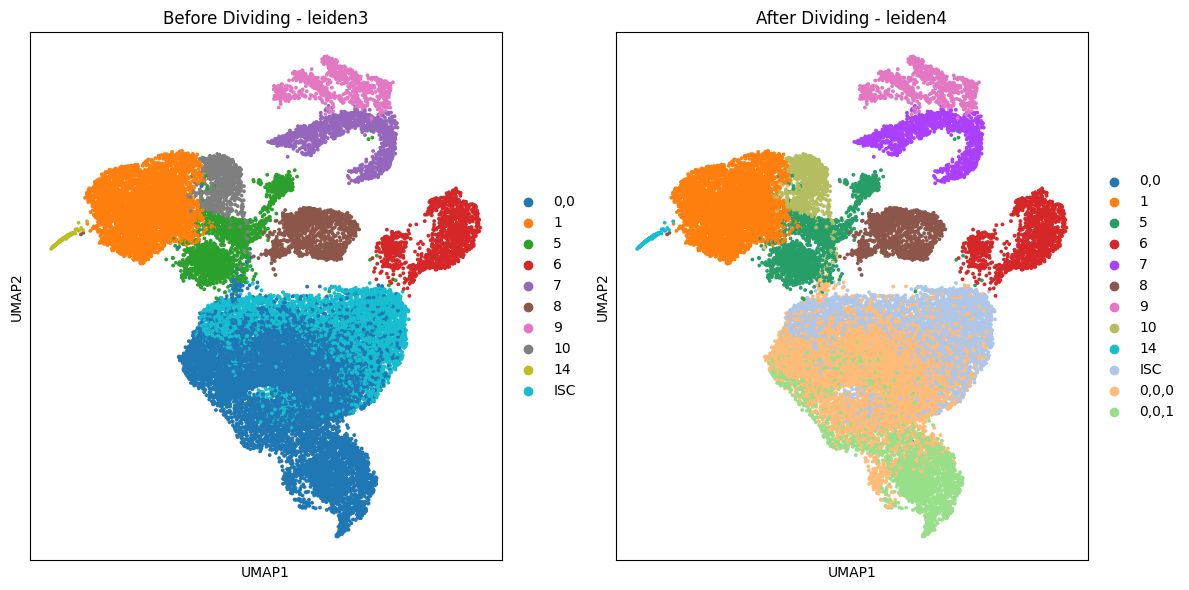

In [257]:
# divide_cluster_by_expression(adata, genes = marker_dict['Enterocyte'], cluster_name = '0,0', annotation='leiden3', x=0.2)

## Misc. Code Below

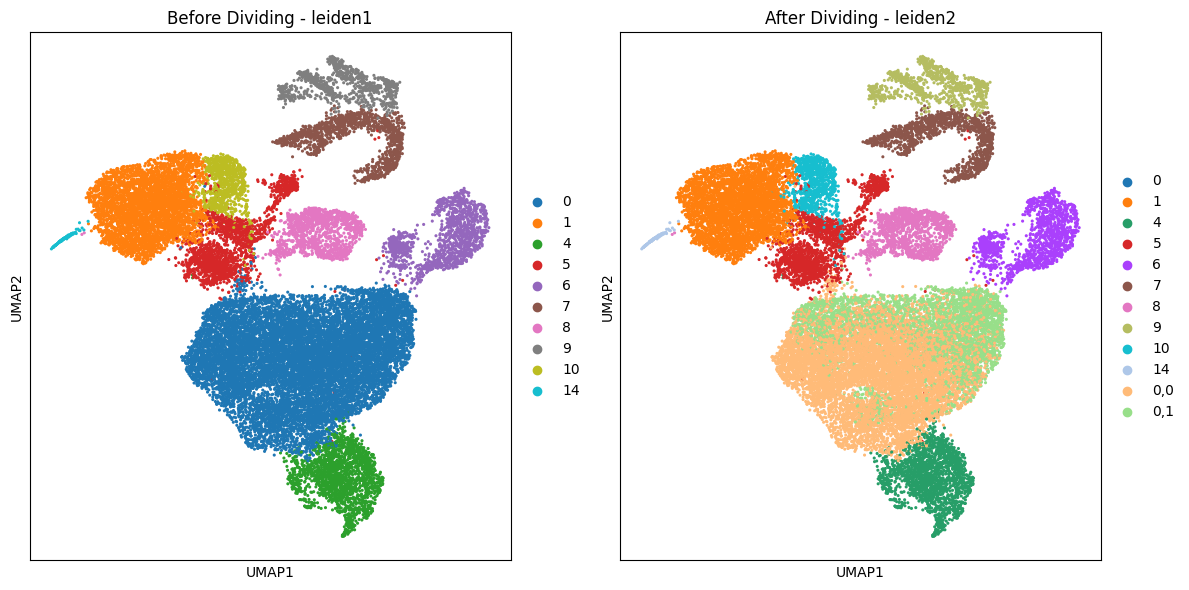

In [126]:
divide_cluster_by_expression(adata, marker_dict['ISC'], '0', annotation='leiden1', x=0.3, size = 20, fig_size=1)

In [130]:
adata.obs

Sample   Diet  n_genes_by_counts  \
AAACCTGAGAGTAAGG-1-CD_1    CD_1     CD               3799   
AAACCTGAGGTGATTA-1-CD_1    CD_1     CD               3403   
AAACCTGCAAGTAGTA-1-CD_1    CD_1     CD               3443   
AAACCTGCACACCGAC-1-CD_1    CD_1     CD               4623   
AAACCTGGTACACCGC-1-CD_1    CD_1     CD               1647   
...                         ...    ...                ...   
TTTGTCAGTCGTTGTA-1-HFD_3  HFD_3  HFHSD               3383   
TTTGTCAGTCTTGATG-1-HFD_3  HFD_3  HFHSD               4196   
TTTGTCATCAAGAAGT-1-HFD_3  HFD_3  HFHSD               3351   
TTTGTCATCAGGCCCA-1-HFD_3  HFD_3  HFHSD               5146   
TTTGTCATCATTATCC-1-HFD_3  HFD_3  HFHSD               4147   

                          log1p_n_genes_by_counts  total_counts  \
AAACCTGAGAGTAAGG-1-CD_1                  8.242756       18155.0   
AAACCTGAGGTGATTA-1-CD_1                  8.132706       16465.0   
AAACCTGCAAGTAGTA-1-CD_1                  8.144389       10361.0   
AAACCTGCACACCGAC-1-CD_1                  8.439015       24954.0   
AAACCTGGTACACCGC-1-CD_1                  7.407318        4687.0   
...                                           ...           ...   
TTTGTCAGTCGTTGTA-1-HFD_3                 8.126814       16692.0   
TTTGTCAGTCTTGATG-1-HFD_3                 8.342125       19903.0   
TTTGTCATCAAGAAGT-1-HFD_3                 8.117312       14153.0   
TTTGTCATCAGGCCCA-1-HFD_3                 8.546169       30819.0   
TTTGTCATCATTATCC-1-HFD_3                 8.330382       18467.0   

                          log1p_total_counts  pct_counts_in_top_50_genes  \
AAACCTGAGAGTAAGG-1-CD_1             9.806756                   32.277609   
AAACCTGAGGTGATTA-1-CD_1             9.709053                   34.388096   
AAACCTGCAAGTAGTA-1-CD_1             9.245900                   24.756298   
AAACCTGCACACCGAC-1-CD_1            10.124829                   23.711629   
AAACCTGGTACACCGC-1-CD_1             8.452762                   33.240879   
...                                      ...                         ...   
TTTGTCAGTCGTTGTA-1-HFD_3            9.722745                   35.999281   
TTTGTCAGTCTTGATG-1-HFD_3            9.898676                   28.030950   
TTTGTCATCAAGAAGT-1-HFD_3            9.557753                   26.842366   
TTTGTCATCAGGCCCA-1-HFD_3           10.335919                   26.710795   
TTTGTCATCATTATCC-1-HFD_3            9.823794                   26.371365   

                          pct_counts_in_top_100_genes  \
AAACCTGAGAGTAAGG-1-CD_1                     48.366841   
AAACCTGAGGTGATTA-1-CD_1                     49.219557   
AAACCTGCAAGTAGTA-1-CD_1                     34.745681   
AAACCTGCACACCGAC-1-CD_1                     37.320670   
AAACCTGGTACACCGC-1-CD_1                     49.839983   
...                                               ...   
TTTGTCAGTCGTTGTA-1-HFD_3                    49.982027   
TTTGTCAGTCTTGATG-1-HFD_3                    41.752500   
TTTGTCATCAAGAAGT-1-HFD_3                    40.288278   
TTTGTCATCAGGCCCA-1-HFD_3                    40.001298   
TTTGTCATCATTATCC-1-HFD_3                    39.307955   

                          pct_counts_in_top_200_genes  \
AAACCTGAGAGTAAGG-1-CD_1                     59.195814   
AAACCTGAGGTGATTA-1-CD_1                     60.024294   
AAACCTGCAAGTAGTA-1-CD_1                     44.831580   
AAACCTGCACACCGAC-1-CD_1                     50.585077   
AAACCTGGTACACCGC-1-CD_1                     60.657137   
...                                               ...   
TTTGTCAGTCGTTGTA-1-HFD_3                    61.047208   
TTTGTCAGTCTTGATG-1-HFD_3                    52.971914   
TTTGTCATCAAGAAGT-1-HFD_3                    53.147743   
TTTGTCATCAGGCCCA-1-HFD_3                    51.406600   
TTTGTCATCATTATCC-1-HFD_3                    50.300536   

                          pct_counts_in_top_500_genes  ...  predicted_doublet  \
AAACCTGAGAGTAAGG-1-CD_1                     70.851005  ...              False   
AAACCTGAGGTGATTA-1-CD_1                   

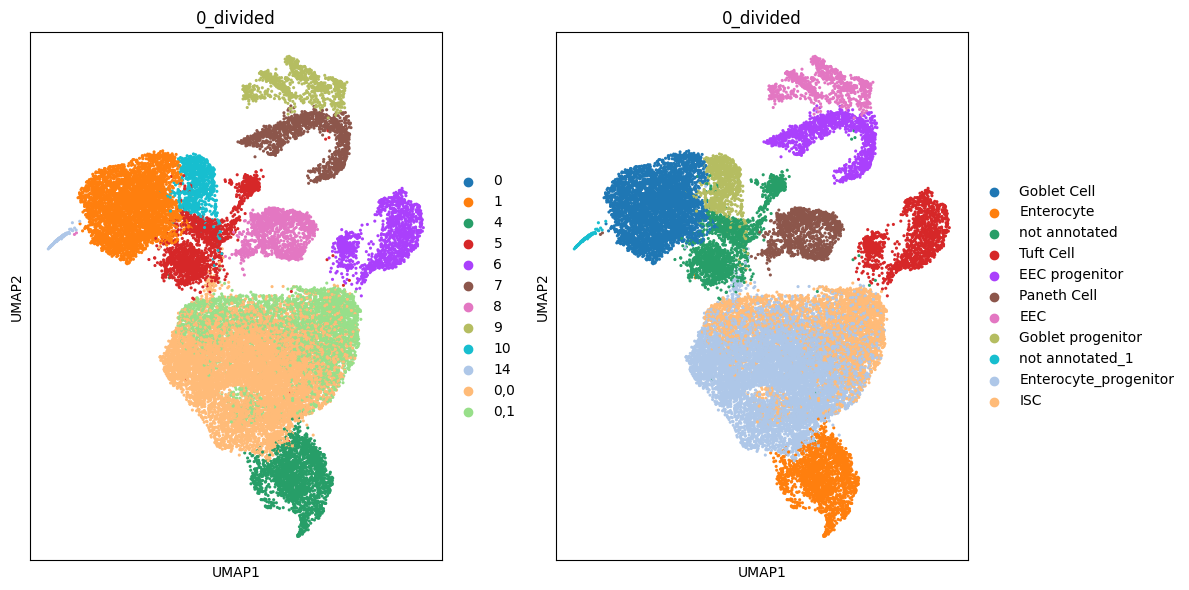

In [116]:
rename_dict = {
    '0' : 'NA',
    '1' : 'Goblet Cell',
    '4' : 'Enterocyte',
    '5' : 'not annotated',
    '6' : 'Tuft Cell',
    '7' : 'EEC progenitor',
    '8' : 'Paneth Cell',
    '9' : 'EEC',
    '10' : 'Goblet progenitor',
    '14' : 'not annotated_1',
    '0,0' : 'Enterocyte_progenitor',
    '0,1' : 'ISC',
}

rename_clusters(adata, annotation = '0_divided', rename_dict = rename_dict)

In [117]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd

def measure_cluster_agreement(adata, annotation1, annotation2):
    """
    Measure the agreement between clusters from two different annotations.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation1 : str
        The name of the first annotation column in `adata.obs`.
    annotation2 : str
        The name of the second annotation column in `adata.obs`.

    Returns:
    --------
    agreement_metrics : dict
        A dictionary containing the Adjusted Rand Index (ARI) and a contingency table.
    """
    # Extract the cluster labels from the two annotations
    labels1 = adata.obs[annotation1]
    labels2 = adata.obs[annotation2]

    # Calculate the Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(labels1, labels2)

    # Create a contingency table to see the overlap between clusters
    contingency_table = pd.crosstab(labels1, labels2)

    # Return a dictionary with the ARI and the contingency table
    agreement_metrics = {
        'Adjusted Rand Index (ARI)': ari,
        'Contingency Table': contingency_table
    }

    return agreement_metrics


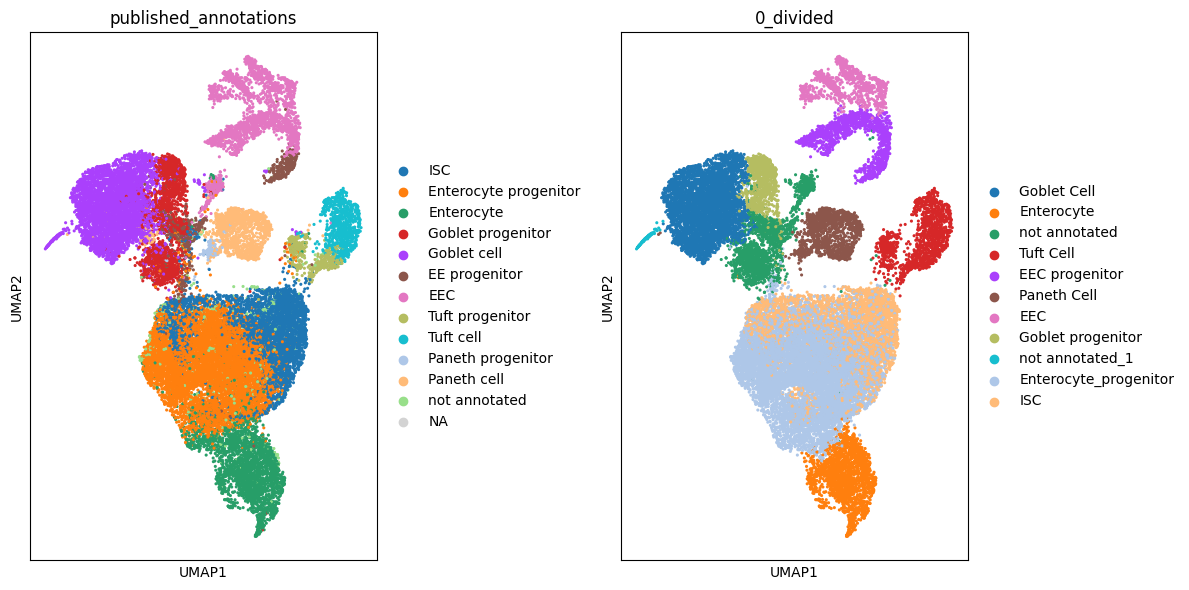

In [118]:
compare_annotations(adata, annotation_1='published_annotations', annotation_2='0_divided')

## Filter Lymphocyte Cells

In [ ]:
# lymphocyte markers
sc.pl.violin(adata, keys=['Coro1a', 'Cd52', 'Cd37'], groupby='leiden', inner="box", stripplot=False)

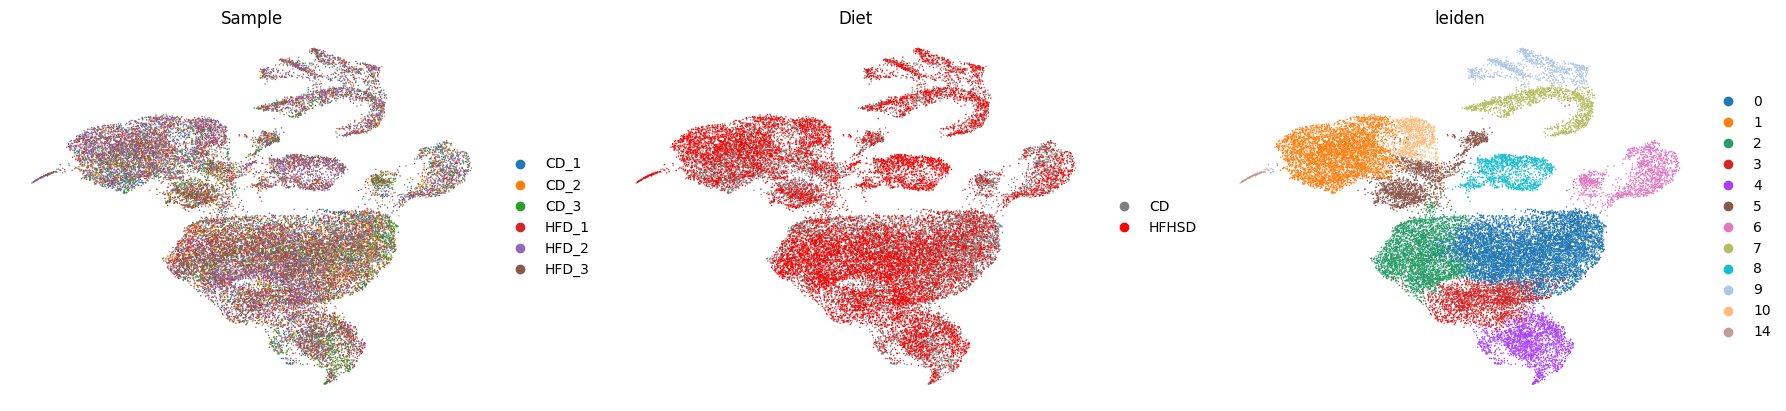

In [ ]:
# Remove lymphocytes and replot
# mask = ~adata.obs.leiden.isin(['11','12', '13', '15']) # Check these match the above plots
adata = adata[mask].copy()

sc.pl.umap(
    adata,
    color=["Sample", "Diet"],
    ncols=3,
    frameon=False
)